In [96]:
import cv2
import os
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from sklearn.model_selection import KFold


In [97]:
#pip install opencv-python

In [98]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()#train = 60.000, test = 10.000 Datensätze



In [99]:
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)



In [100]:

def define_model():
    model = tf.keras.models.Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))# - Zahlen auf 0 setzen
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))# 128 Neuronen, zwei Neuronen Layer, bei 3 war es schlechter, bei 1 auch schlechter. Accuracy mit 3 Layern = 0.9965
    model.add(tf.keras.layers.Dense(10, activation='softmax')) #alle zusammen = 1 jedes neuron hat eine Zahl zwischen 0 und 1. Probality of each digit

    model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics =['accuracy'])
    model.fit(x_train, y_train, epochs= 9) # 9 Epochen, bei 10 Epochen war eine schelchtere Accuracy, bis 9 ist die Accuracy besser geworden und die Loss weniger
    model.save('handwritten.model')
    return model





In [101]:
#Durchführen, falls das Model nicht erneuet trainiert werden soll, Lädt das bereits trainierte Modell neu ein
#model = tf.keras.models.load_model('handwritten.model') # Laden des Models
#loss, accuracy = model.evaluate(x_test, y_test)

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=2):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		x_train, y_train, x_test, y_test = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(x_train, y_train, epochs=9, batch_size=32, validation_data=(x_test, y_test), verbose=0)
		# evaluate model
		_, acc = model.evaluate(x_test, y_test, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

In [111]:


# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		plt.subplot(2, 1, 1)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
		plt.tight_layout(pad=1.5)
	plt.show

In [109]:
scores, histories = evaluate_model(x_train, y_train)
summarize_diagnostics(histories)

Epoch 1/9
  92/1875 [>.............................] - ETA: 32s - loss: 0.6533 - accuracy: 0.8115

KeyboardInterrupt: 

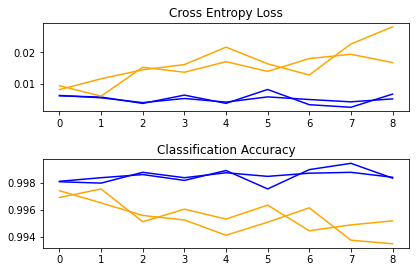

In [112]:
summarize_diagnostics(histories)

In [104]:
#Erzeugen der Funktion, damit eine PNG mit 28x28 Größe die Zahl predicted werden kann.
def predicthandwritten(path): 
 img = cv2.imread(path)[:,:,0]
 img = np.invert(np.array([img]))
 prediction = model.predict(img)
 print(prediction)
 plt.imshow(img[0])
 plt.show()
 print("Die Vorhersage lautet: " , np.argmax(prediction) )
 



313/313 [==============================] - 1s 4ms/step
9


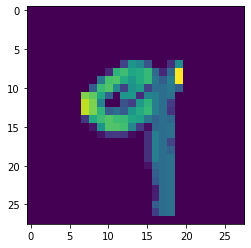

In [105]:
#Bild 322 des x_test predicten
predictions = model.predict(x_test)
print(np.argmax(predictions[322]))
plt.imshow(x_test[322])
plt.show()


1/1 [==============================] - 0s 16ms/step
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


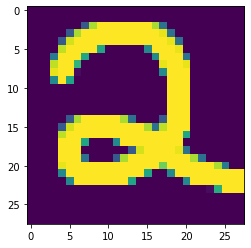

Die Vorhersage lautet:  2


In [106]:
#Bild mit dem Namen 7.png vorhersagen
predicthandwritten("2.png")

Text(69.0, 0.5, 'Tatsächlicher Wert')

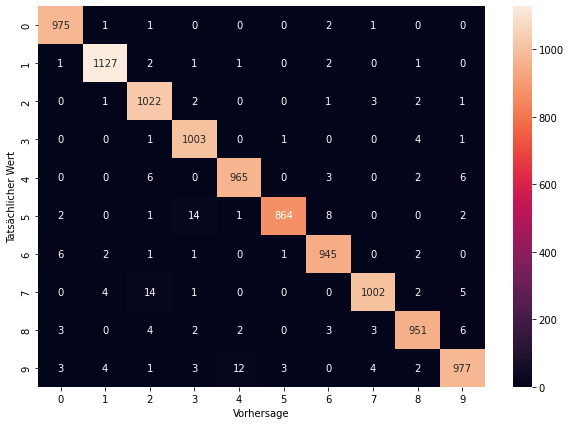

In [107]:
#Confusionsmatrix erstellen über den x_test Datensatz
prediction_labels = [np.argmax(i) for i in predictions]

confusionmatrix = tf.math.confusion_matrix(labels=y_test, predictions=prediction_labels)

plt.figure(figsize = (10, 7))
sn.heatmap(confusionmatrix, annot=True, fmt='d')
plt.xlabel('Vorhersage')
plt.ylabel('Tatsächlicher Wert')